# perform authorization
[apt-key](https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force)

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!pip install pykalman


In [0]:
import pandas as pd
import numpy as np

import re
import os
import csv

from pykalman import KalmanFilter
import matplotlib.pyplot as plt

In [0]:
path = "drive/capstone/"

# CCL

In [0]:
CCL = pd.read_csv(path+"datas/CCL.csv", sep="\t")

In [143]:
CCL.shape

(1252, 2)

In [144]:
CCL.head()

,Date,CCL
0,2017/12/25-2017/12/31,165.02
1,2017/12/18-2017/12/24,165.62
2,2017/12/11-2017/12/17,165.30
3,2017/12/04-2017/12/10,164.46
4,2017/11/27-2017/12/03,163.29


In [0]:
# Set up the filter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = CCL['CCL'].values[0],
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

state_means, state_covs = kf.filter(CCL.CCL)

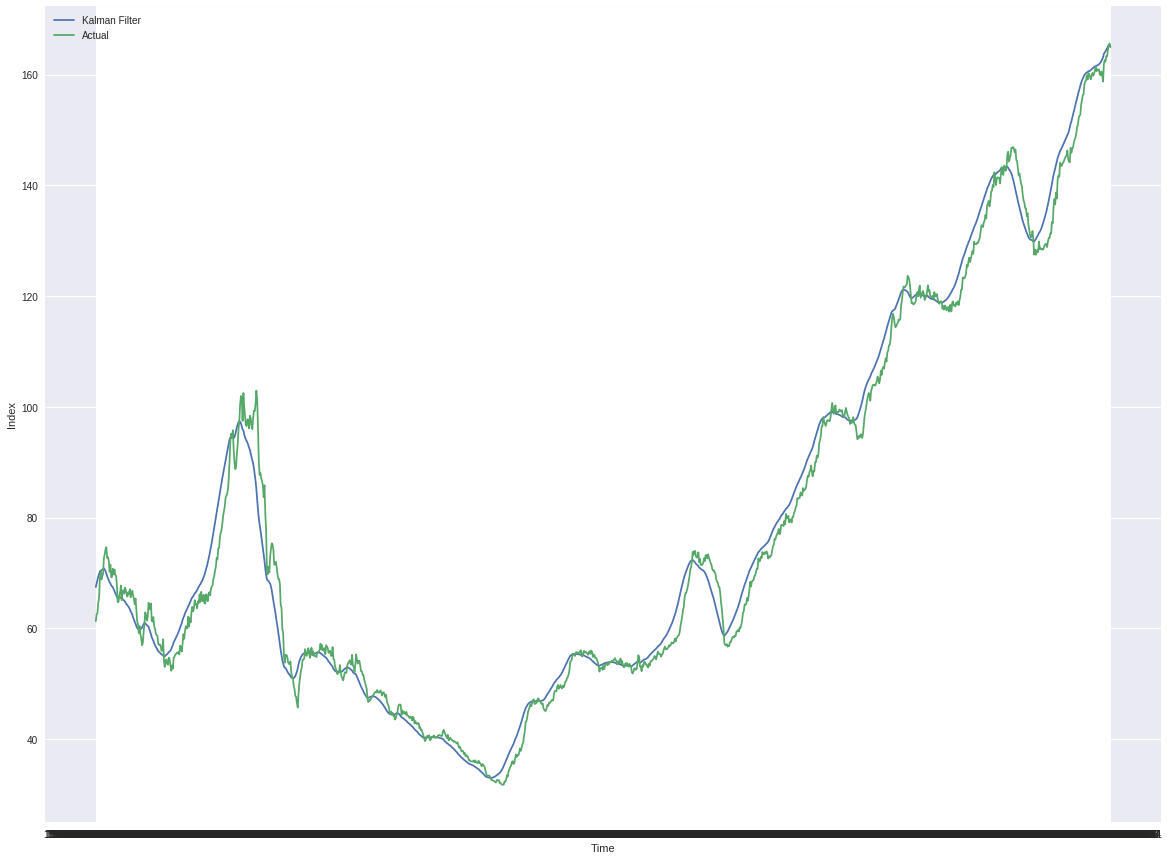

In [146]:
plt.figure(figsize=(20,15))
plt.plot(CCL.Date, state_means[:,0])
plt.plot(CCL.Date, CCL.CCL)
plt.legend(['Kalman Filter', 'Actual'])
plt.xlabel('Time')
plt.ylabel('Index');

In [0]:
CCL["CCL_kalman"] = state_means

In [0]:
def get_Date(s):
  return s.split("-")[1]

In [0]:
CCL["Date"] = CCL["Date"].apply(get_Date)
CCL["Date"] = pd.to_datetime(CCL.Date, format="%Y-%m-%d", errors='ignore')

In [0]:
CCL.set_index("Date", inplace=True)

In [0]:
CCL["CCL_lastweek"] =  CCL.CCL.shift(-1)

In [0]:
CCL["CCL_kalman_lastweek"] = CCL.CCL_kalman.shift(-1)

In [0]:
CCL["rise_CCL"] = (CCL.CCL_kalman/CCL.CCL_kalman_lastweek >= 1).astype(int)

In [0]:
CCL["change_CCL"] = (CCL.CCL/CCL.CCL_lastweek-1)*100

In [155]:
CCL.head()

,CCL,CCL_kalman,CCL_lastweek,CCL_kalman_lastweek,rise_CCL,change_CCL
Date,,,,,,
2017-12-31,165.02,165.020000,165.62,165.222649,0,-0.362275
2017-12-24,165.62,165.222649,165.30,165.242607,0,0.193587
2017-12-17,165.30,165.242607,164.46,165.077188,1,0.510762
2017-12-10,164.46,165.077188,163.29,164.753265,1,0.716517
2017-12-03,163.29,164.753265,163.34,164.526374,1,-0.030611


In [156]:
CCL.shape

(1252, 6)

# Hong Kong Bonds

In [0]:
hkbonds = pd.read_csv(path+"datas/hkbonds.csv")

In [158]:
hkbonds.head()

,Date,Price,Open,High,Low,Change %
0,"Apr 25, 2017",1.451,1.413,1.451,1.413,2.69%
1,"Apr 24, 2017",1.413,1.374,1.413,1.374,1.22%
2,"Apr 23, 2017",1.396,1.396,1.396,1.396,0.00%
3,"Apr 22, 2017",1.396,1.396,1.396,1.396,0.00%
4,"Apr 21, 2017",1.396,1.396,1.396,1.396,0.00%


In [0]:
hkbonds["Date"] = pd.to_datetime(hkbonds.Date, format="%b %d, %Y", errors='ignore')

In [0]:
hkbonds.set_index("Date", inplace=True)

In [161]:
hkbonds.head()

,Price,Open,High,Low,Change %
Date,,,,,
2017-04-25,1.451,1.413,1.451,1.413,2.69%
2017-04-24,1.413,1.374,1.413,1.374,1.22%
2017-04-23,1.396,1.396,1.396,1.396,0.00%
2017-04-22,1.396,1.396,1.396,1.396,0.00%
2017-04-21,1.396,1.396,1.396,1.396,0.00%


In [0]:
hkbonds = hkbonds.groupby(pd.Grouper(freq='W'))['Price'].mean().to_frame().rename(index=str, columns={"Price":"hkbonds_price"})

In [163]:
hkbonds.columns

Index(['hkbonds_price'], dtype='object')

In [0]:
hkbonds["hkbonds_change"] = (hkbonds.shift(1)/hkbonds.shift(2)-1)*100

In [0]:
hkbonds.drop("hkbonds_price", axis=1, inplace=True)

In [166]:
hkbonds.head()

,hkbonds_change
Date,
1998-01-18 00:00:00,NaN
1998-01-25 00:00:00,NaN
1998-02-01 00:00:00,0.100241
1998-02-08 00:00:00,0.465652
1998-02-15 00:00:00,-0.656865


In [167]:
hkbonds.shape

(1007, 1)

# Fed-Fund

In [0]:
fed = pd.read_csv(path+"datas/fed-fund.csv")

In [169]:
fed.head()

,date,value
0,1954-07-01,1.13
1,1954-07-02,1.25
2,1954-07-03,1.25
3,1954-07-04,1.25
4,1954-07-05,0.88


In [0]:
fed = fed.rename(index=str, columns={"date":"Date", " value":"fed"})
fed["Date"] = pd.to_datetime(fed.Date, format="%Y-%m-%d", errors='ignore')

In [0]:
fed.set_index("Date", inplace=True)

In [0]:
fed = fed.groupby(pd.Grouper(freq='W')).mean()

In [0]:
fed["fed_change"] = (fed.shift(1)/fed.shift(2)-1)*100

In [0]:
fed.drop("fed", axis=1, inplace=True)

In [175]:
fed.head()

,fed_change
Date,
1954-07-04,NaN
1954-07-11,NaN
1954-07-18,-16.510539
1954-07-25,-8.695652
1954-08-01,-38.556068


In [176]:
fed.shape

(3332, 1)

# HSI

In [0]:
HSI = pd.read_csv(path+"datas/HSI.csv")

In [178]:
HSI.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"May 03, 2018","30,163.00","30,265.00","30,300.50","30,078.50",-,-1.83%
1,"May 02, 2018","30,723.88","30,782.21","30,824.77","30,570.81",1.69B,-0.27%
2,"Apr 30, 2018","30,808.45","30,530.40","30,853.13","30,483.91",1.98B,1.74%
3,"Apr 27, 2018","30,280.67","30,300.83","30,336.00","30,019.12",1.66B,0.91%
4,"Apr 26, 2018","30,007.68","30,378.15","30,463.42","29,871.20",1.82B,-1.06%


In [0]:
HSI["Date"] = pd.to_datetime(HSI.Date, format="%b %d, %Y", errors='ignore')

In [0]:
HSI.set_index("Date", inplace=True)

In [181]:
HSI.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-05-03,"30,163.00","30,265.00","30,300.50","30,078.50",-,-1.83%
2018-05-02,"30,723.88","30,782.21","30,824.77","30,570.81",1.69B,-0.27%
2018-04-30,"30,808.45","30,530.40","30,853.13","30,483.91",1.98B,1.74%
2018-04-27,"30,280.67","30,300.83","30,336.00","30,019.12",1.66B,0.91%
2018-04-26,"30,007.68","30,378.15","30,463.42","29,871.20",1.82B,-1.06%


In [0]:
HSI["Price"] = HSI["Price"].apply(lambda s: float(s.replace(',','')))

In [0]:
HSI = HSI.groupby(pd.Grouper(freq='W'))["Price"].mean().to_frame().rename(index=str, columns={"Price":"HSI_price"})

In [0]:
HSI["HSI_change"] = (HSI.shift(1)/HSI.shift(2)-1)*100

In [0]:
HSI.drop("HSI_price", axis=1, inplace=True)

In [186]:
HSI.head()

,HSI_change
Date,
2000-12-10 00:00:00,NaN
2000-12-17 00:00:00,NaN
2000-12-24 00:00:00,2.660468
2000-12-31 00:00:00,-2.982557
2001-01-07 00:00:00,-0.187933


In [187]:
HSI.shape

(909, 1)

# DJIA

In [0]:
DJIA = pd.read_csv(path+"datas/DJIA.csv")

In [189]:
DJIA.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000
1,1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000
2,1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000
3,1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000
4,1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000


In [0]:
DJIA = DJIA.rename(index=str, columns={"Close":"DJIA"})

In [0]:
DJIA["Date"] = pd.to_datetime(DJIA.Date, format="%Y-%m-%d", errors='ignore')

In [0]:
DJIA.set_index("Date",inplace=True)

In [0]:
DJIA = DJIA.groupby(pd.Grouper(freq='W'))["DJIA"].mean().to_frame()

In [0]:
DJIA["DJIA_change"] = (DJIA.shift(1)/DJIA.shift(2)-1)*100

In [0]:
DJIA.drop("DJIA", axis=1, inplace=True)

In [196]:
DJIA.head()

,DJIA_change
Date,
1985-02-03,NaN
1985-02-10,NaN
1985-02-17,0.073273
1985-02-24,-0.240209
1985-03-03,-0.346393


# US dollar index

In [0]:
USDI = pd.read_csv(path+"datas/USDI.csv")

In [198]:
USDI.isnull().sum()

date      0
 value    0
dtype: int64

In [199]:
USDI.head()

,date,value
0,1973-01-01,107.616
1,1973-02-01,103.046
2,1973-03-01,100.000
3,1973-04-01,100.376
4,1973-05-01,99.263


In [0]:
USDI = USDI.rename(index=str, columns={"date":"Date", " value":"USDI"})

In [0]:
USDI["Date"] = pd.to_datetime(USDI.Date, format="%Y-%m-%d", errors='ignore')

In [0]:
USDI.set_index("Date",inplace=True)

In [0]:
USDI = USDI.groupby(pd.Grouper(freq='W')).mean()

In [0]:
USDI.fillna(method = "ffill",inplace=True)

In [0]:
USDI["USDI_change"] = (USDI.shift(1)/USDI.shift(2)-1)*100

In [0]:
USDI.drop("USDI", axis=1, inplace=True)

In [207]:
USDI.head()

,USDI_change
Date,
1973-01-07,NaN
1973-01-14,NaN
1973-01-21,0.0
1973-01-28,0.0
1973-02-04,0.0


In [208]:
USDI.shape

(2361, 1)

# hibor

In [0]:
hibor = pd.read_csv(path+"datas/hibor.csv", index_col=0)

In [0]:
hibor["Date"] = pd.to_datetime(hibor.Date, format="%d %B-%Y", errors='ignore')

In [0]:
hibor.set_index("Date", inplace=True)

In [0]:
hibor["Hibor"] = hibor["Hibor"].apply(lambda s: float(s.split("%")[0])/100)

In [0]:
hibor = hibor.groupby(pd.Grouper(freq='W')).mean()

In [0]:
hibor["Hibor_change"] = hibor.shift(1)/hibor.shift(2)-1

In [0]:
hibor.drop("Hibor", axis=1, inplace=True)

In [216]:
hibor.head()

,Hibor_change
Date,
2011-01-09,NaN
2011-01-16,NaN
2011-01-23,-0.113636
2011-01-30,-0.051282
2011-02-06,-0.087838


In [217]:
hibor.shape

(383, 1)

# unemployment rate

In [0]:
unemployment = pd.read_csv(path+"datas/unemployment.csv", header=None, names=["Date","unemployment"])

In [0]:
unemployment["Date"] = pd.to_datetime(unemployment.Date, format="%Y/%m/%d", errors='ignore')

In [0]:
unemployment.set_index("Date", inplace=True)

In [221]:
unemployment.head()

,unemployment
Date,
2018-05-27,0.029
2018-05-20,0.029
2018-05-13,0.029
2018-05-06,0.029
2018-04-29,0.029


# SCMP

In [0]:
scmp = pd.read_csv(path+"datas/scmp_news.csv", encoding = "ISO-8859-1", index_col=0)

In [223]:
scmp.head()

,created_at,favorite_count,id_str,in_reply_to_screen_name,is_retweet,retweet_count,source,text
0,Wed Oct 15 10:49:07 +0000 2014,2,522338371721768961,NaN,False,0,SocialFlow,"22,000 civil service jobs are up for grabs in ..."
1,Thu Sep 04 07:30:07 +0000 2014,3,507430393034080257,NaN,False,5,SocialFlow,Japan names five women to new cabinet of Prime...
2,Tue Nov 05 06:31:09 +0000 2013,0,397612029126918144,NaN,False,0,Hootsuite,RT @BloombergNews: Thai protesters rally in Ba...
3,Sat Jun 13 07:10:14 +0000 2015,1,609618764745805825,NaN,False,3,Hootsuite,Hong Kong's Able Friend edged for favouritism ...
4,Thu May 08 23:20:12 +0000 2014,1,464545330835783680,NaN,False,5,Hootsuite,Our map of all publicly accessible toilets in ...


In [0]:
def cleanURLs(text):
    return re.sub('http\S+','', text)
scmp["text"] = scmp["text"].apply(cleanURLs)

In [0]:
datetime_format = "%a %b %d %H:%M:%S +0000 %Y"
scmp["Date"] = pd.to_datetime(scmp.created_at, format=datetime_format, errors='ignore')
scmp = scmp[["Date","text"]].sort_values(by="Date").set_index("Date")

In [0]:
scmp = scmp.groupby(pd.Grouper(freq='W'))['text'].apply(lambda x: "%s" % ' '.join(x)).shift(1)

In [227]:
scmp.shape

(477,)

In [0]:
import requests
import json

#def get_sentiment(text):
#  url = "https://japerk-text-processing.p.mashape.com/sentiment/"
#  params = { "language": "english","text": text }
#  headers={"X-Mashape-Key": "rY75Q4dpKYmsh8wF7jIk9K108pCtp1hsrrojsnPSEbpILVpE8E","Content-Type": "application/x-www-form-urlencoded","Accept": "application/json"}
#  r = requests.post(url, data=params, headers=headers)
#  d = json.loads(r.text)
#  return d['probability']

In [0]:
#get_sentiment(scmp[448][:5000])

In [0]:
#neg=[]
#neutral=[]
#pos=[]

#for text in scmp.astype(str):
#  if text != '':
#    if len(text)>5000:
#      text=text[:5000]
#    senti = get_sentiment(text)
#    neg.append(senti["neg"])
#    neutral.append(senti["neutral"])
#    pos.append(senti["pos"])
#  else:
#    neg.append(0.0)
#    neutral.append(1.0)
#    pos.append(0.0)

In [0]:
#sentiment=pd.DataFrame({"Date":scmp.index.values, "neg":neg, "neutral":neutral, "pos":pos}).set_index("Date")
sentiment = pd.read_csv(path+"datas/sentiment.csv")
sentiment["Date"] = pd.to_datetime(sentiment.Date, format="%Y-%m-%d", errors='ignore')
sentiment.set_index("Date", inplace=True)

In [0]:
sentiment = sentiment.shift(1)

In [233]:
sentiment.head()

,neg,neutral,pos
Date,,,
2009-03-15,NaN,NaN,NaN
2009-03-22,NaN,NaN,NaN
2009-03-29,NaN,NaN,NaN
2009-04-05,NaN,NaN,NaN
2009-04-12,NaN,NaN,NaN


# 28house

In [0]:
hse_price = pd.read_csv(path+"datas/avg_house_price.csv")

In [0]:
hse_price["Date"] = hse_price.Date.apply(lambda x: x.split(" ")[0])

In [0]:
hse_price["Date"] = pd.to_datetime(hse_price.Date, format="%Y-%m-%d", errors='ignore')

In [0]:
hse_price.set_index("Date", inplace=True)

In [0]:
hse_price = hse_price.shift(1)

In [239]:
hse_price.head()

,nt_sq_price_value,kl_sq_price_value,hk_sq_price_value
Date,,,
2008-06-01,NaN,NaN,NaN
2008-06-08,4266.089216,4778.665411,6012.728022
2008-06-15,4776.773055,4701.550153,5752.118793
2008-06-22,3827.099790,4458.781951,5487.746649
2008-06-29,3241.915320,6152.033340,5292.952000


# merge

In [240]:
lis = ["CCL","hkbonds","fed","HSI","DJIA","USDI","hibor", "unemployment", "hse_price"]
for i in lis:
  print("{}:{}".format(i,str(eval(i).shape)))

CCL:(1252, 6)
hkbonds:(1007, 1)
fed:(3332, 1)
HSI:(909, 1)
DJIA:(1736, 1)
USDI:(2361, 1)
hibor:(383, 1)
unemployment:(1749, 1)
hse_price:(520, 3)


In [0]:
data = pd.merge(CCL, hkbonds, left_index=True, right_index=True)
data = pd.merge(data, fed, left_index=True, right_index=True)
data = pd.merge(data, HSI, left_index=True, right_index=True)
data = pd.merge(data, DJIA, left_index=True, right_index=True)
data = pd.merge(data, USDI, left_index=True, right_index=True)
data = pd.merge(data, unemployment, left_index=True, right_index=True)
#data = pd.merge(data, hibor, left_index=True, right_index=True)
#data = pd.merge(data, sentiment, left_index=True, right_index=True)
data = pd.merge(data, hse_price, left_index=True, right_index=True)

In [0]:
data.drop(columns=["rise_CCL","change_CCL"], inplace=True)

In [0]:
data = data.dropna()

In [244]:
data.head()

,CCL,CCL_kalman,CCL_lastweek,CCL_kalman_lastweek,hkbonds_change,fed_change,HSI_change,DJIA_change,USDI_change,unemployment,nt_sq_price_value,kl_sq_price_value,hk_sq_price_value
Date,,,,,,,,,,,,,
2017-04-30,155.45,158.924455,154.57,158.509801,-6.586486,0.000000,-1.110520,-0.244676,0.000000,0.033,8261.494423,10636.164264,11801.812541
2017-04-23,154.57,158.509801,152.77,157.963331,-5.992937,0.000000,-0.285484,-0.351975,0.000000,0.033,7972.373653,10436.507910,12027.005238
2017-04-16,152.77,157.963331,152.57,157.449928,-1.574320,4.426230,0.131712,0.003038,0.000000,0.033,8114.575089,9973.137783,11604.513333
2017-04-09,152.57,157.449928,152.18,156.948336,-4.890617,-4.238619,-0.620132,-0.178724,-0.859142,0.033,8107.380150,10454.349159,11863.582167
2017-04-02,152.18,156.948336,150.89,156.371764,-9.317060,13.345196,1.709981,-0.985139,0.000000,0.033,8024.228730,10408.248223,11149.322410


In [245]:
data.tail()

,CCL,CCL_kalman,CCL_lastweek,CCL_kalman_lastweek,hkbonds_change,fed_change,HSI_change,DJIA_change,USDI_change,unemployment,nt_sq_price_value,kl_sq_price_value,hk_sq_price_value
Date,,,,,,,,,,,,,
2008-07-06,72.77,68.211578,73.38,68.703224,-2.657270,1.608187e+00,-2.307417,-3.483305,0.000000,0.042,3067.516366,4839.385277,5271.816034
2008-06-29,73.38,68.703224,72.62,69.075807,4.294562,-2.285714e+00,-0.383374,-1.208717,0.000000,0.043,3241.915320,6152.033340,5292.952000
2008-06-22,72.62,69.075807,73.24,69.471925,12.683293,-1.110223e-14,-5.401145,-1.623906,0.000000,0.043,3827.099790,4458.781951,5487.746649
2008-06-15,73.24,69.471925,73.23,69.829412,3.696399,-1.754386e+00,0.338776,-1.463091,0.000000,0.043,4776.773055,4701.550153,5752.118793
2008-06-08,73.23,69.829412,72.16,70.051109,6.874278,1.858470e+00,-3.609950,-0.833233,0.584837,0.043,4266.089216,4778.665411,6012.728022


In [246]:
data.shape

(465, 13)

In [0]:
from datetime import datetime
train = data[data.index < datetime.strptime('2014-01-01', '%Y-%m-%d')]
test = data[data.index > datetime.strptime('2013-12-31', '%Y-%m-%d')]

In [248]:
!pip install xgboost
!pip install scikit-mdr skrebate
!pip install tpot

In [0]:
columns = [ "CCL_kalman_lastweek","hkbonds_change", "fed_change", "HSI_change", "DJIA_change", "USDI_change"]

X_train = train.iloc[:,3:].values
y_train = train.CCL.values

X_test = test.iloc[:,3:].values
y_test = test.CCL.values

In [0]:
from tpot import TPOTRegressor

In [0]:
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, scoring="neg_mean_absolute_error")

In [252]:
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, scoring="neg_mean_absolute_error")
tpot.fit(X_train, y_train)

Optimization Progress:  33%|███▎      | 100/300 [00:31<01:43,  1.93pipeline/s]

Generation 1 - Current best internal CV score: -2.184679784396045


Optimization Progress:  50%|█████     | 150/300 [00:42<00:30,  4.89pipeline/s]

Generation 2 - Current best internal CV score: -2.184679784396045


Optimization Progress:  67%|██████▋   | 200/300 [00:54<00:29,  3.41pipeline/s]

Generation 3 - Current best internal CV score: -2.184679784396045


Optimization Progress:  83%|████████▎ | 250/300 [01:04<00:11,  4.40pipeline/s]

Generation 4 - Current best internal CV score: -2.184679784396045


Generation 5 - Current best internal CV score: -2.184448595876785

Best pipeline: LinearSVR(input_matrix, C=20.0, dual=False, epsilon=1.0, loss=squared_epsilon_insensitive, tol=1e-05)


TPOTRegressor(config_dict={'sklearn.linear_model.ElasticNetCV': {'l1_ratio': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]), 'tol': [1e-05, 0.0001, 0.001, 0.01, 0.1]}, 'sklearn.ensemble.ExtraTreesRegressor': {'n_estimato....3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])}}}},
       crossover_rate=0.1, cv=5, disable_update_check=False,
       early_stop=None, generations=5, max_eval_time_mins=5,
       max_time_mins=None, memory=None, mutation_rate=0.9, n_jobs=1,
       offspring_size=50, periodic_checkpoint_folder=None,
       population_size=50, random_state=None, scoring=None, subsample=1.0,
       verbosity=2, warm_start=False)

In [253]:
print(tpot.score(X_test, y_test))
tpot.export(path+'tpot_exported_pipeline.py')

-2.2350517450386507


True

In [0]:
y_pred = tpot.predict(X_test)

In [255]:
print(y_pred)

[156.69291331 155.8800653  155.43349827 155.12224829 154.01162909
 153.41104947 153.253151   152.53484477 151.71047209 150.53127028
 150.08881422 149.48471647 149.41799819 148.82219192 148.218231
 147.74346256 147.25985902 146.7352135  146.34549008 146.44217805
 146.22019966 145.66172195 145.57568037 145.05633953 145.18585326
 144.78468846 144.57371264 144.43856698 143.3348388  143.33443167
 142.21588389 142.21275033 140.84056834 140.64584256 140.05152896
 138.88725816 138.18667287 137.45619454 136.73720153 135.8398604
 134.67758351 134.38138284 134.14644986 133.11362583 133.26012327
 132.25060863 131.45219093 131.15966768 131.25450753 130.91167559
 130.85429839 129.89830479 129.98312419 129.21188889 129.42956949
 128.54493866 128.41751733 128.47815671 127.67579859 127.95093177
 128.51423517 128.05151389 129.26000739 128.79226471 129.84684363
 129.46064664 130.39529372 130.75653852 131.44366274 131.40060862
 130.50247403 132.41121801 132.83374694 134.06095168 134.18937929
 134.40024898

In [256]:
print(y_test)

[155.45 154.57 152.77 152.57 152.18 150.89 150.55 149.38 148.67 148.22
 147.74 146.83 146.59 145.89 146.8  144.16 144.28 144.72 146.3  145.44
 145.17 144.91 144.47 144.08 143.95 143.49 143.68 144.09 141.53 141.77
 141.04 137.62 138.7  136.57 137.5  136.21 133.13 133.41 131.28 131.34
 130.47 130.5  129.84 128.85 129.44 129.38 129.2  128.75 128.37 128.51
 128.41 128.63 128.48 129.87 127.96 128.34 127.84 127.46 128.4  127.5
 130.3  131.76 130.77 130.58 131.01 131.95 132.9  134.95 134.41 135.83
 135.89 136.86 137.3  138.22 139.82 140.27 141.13 142.14 141.76 142.98
 144.33 144.61 146.45 146.01 146.67 146.92 146.76 146.78 145.45 144.84
 144.29 146.07 145.48 143.32 142.62 143.15 143.56 141.87 142.26 143.31
 141.96 140.33 141.3  141.37 141.46 141.22 140.04 141.6  142.36 139.7
 140.05 139.03 138.8  137.12 136.2  137.2  136.64 136.35 134.03 134.64
 133.64 133.34 132.45 132.69 132.81 131.61 130.46 130.16 129.61 129.69
 129.4  129.39 129.38 129.83 127.65 128.14 127.46 126.8  126.14 126.94
 126.2  

In [0]:
from sklearn.metrics import mean_absolute_error

In [258]:
mean_absolute_error(y_pred, y_test)

2.2350517450386507

In [259]:
len(y_pred[2::-1])

3

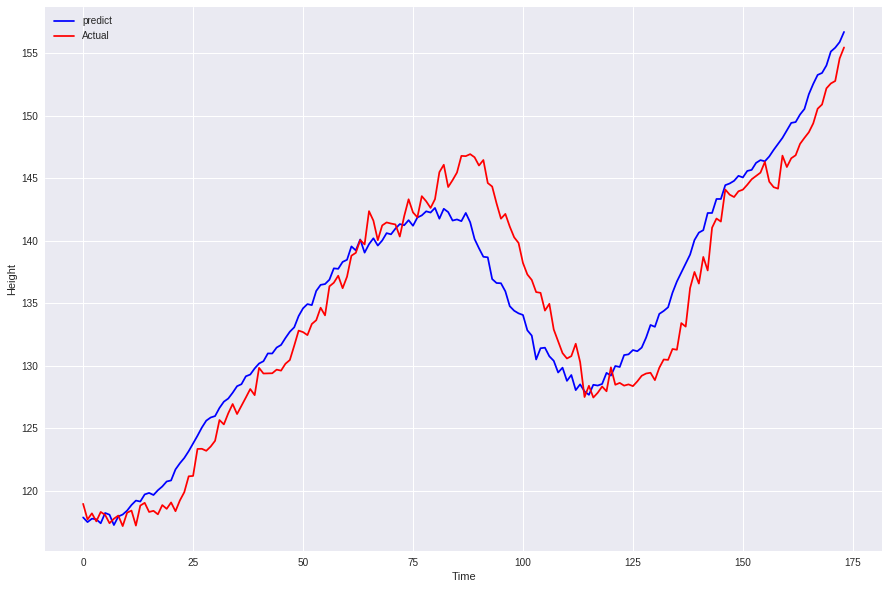

In [260]:
plt.figure(figsize=(15,10))

plt.plot(range(len(y_pred)), y_pred[::-1], c="b")
plt.plot(range(len(y_pred)), y_test[::-1], c="r")

plt.legend(['predict', 'Actual'])
plt.xlabel('Time')
plt.ylabel('Height');

In [0]:
pred = tpot.predict(X_train)

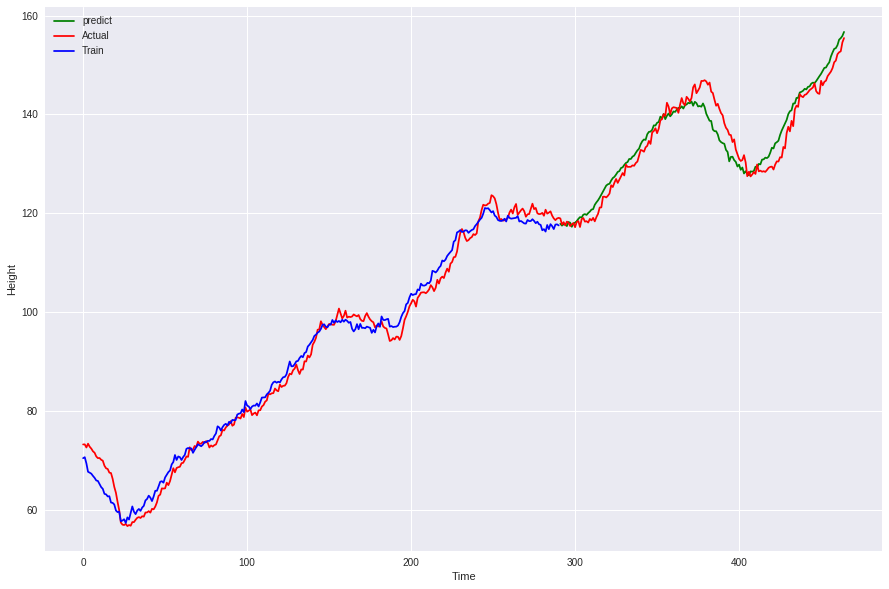

In [262]:
plt.figure(figsize=(15,10))

plt.plot(range(len(pred),len(pred)+len(y_pred)), y_pred[::-1], c="g")
plt.plot(range(len(data["CCL"].values)), data["CCL"][::-1], c="r")
plt.plot(range(len(pred)), pred[::-1], c="b")

plt.legend(['predict', 'Actual', 'Train'])
plt.xlabel('Time')
plt.ylabel('Height');

In [0]:
data["pred_CCL"] = np.concatenate((y_pred,pred))

In [0]:
data[["CCL","pred_CCL"]].to_csv(path+"datas/pred_CCL.csv")

In [265]:
data.tail()

,CCL,CCL_kalman,CCL_lastweek,CCL_kalman_lastweek,hkbonds_change,fed_change,HSI_change,DJIA_change,USDI_change,unemployment,nt_sq_price_value,kl_sq_price_value,hk_sq_price_value,pred_CCL
Date,,,,,,,,,,,,,,
2008-07-06,72.77,68.211578,73.38,68.703224,-2.657270,1.608187e+00,-2.307417,-3.483305,0.000000,0.042,3067.516366,4839.385277,5271.816034,67.521397
2008-06-29,73.38,68.703224,72.62,69.075807,4.294562,-2.285714e+00,-0.383374,-1.208717,0.000000,0.043,3241.915320,6152.033340,5292.952000,67.692813
2008-06-22,72.62,69.075807,73.24,69.471925,12.683293,-1.110223e-14,-5.401145,-1.623906,0.000000,0.043,3827.099790,4458.781951,5487.746649,69.392974
2008-06-15,73.24,69.471925,73.23,69.829412,3.696399,-1.754386e+00,0.338776,-1.463091,0.000000,0.043,4776.773055,4701.550153,5752.118793,70.647984
2008-06-08,73.23,69.829412,72.16,70.051109,6.874278,1.858470e+00,-3.609950,-0.833233,0.584837,0.043,4266.089216,4778.665411,6012.728022,70.452229


In [266]:
data.shape

(465, 14)

In [267]:
-5.0/75

-0.06666666666666667

In [268]:
data.head()

,CCL,CCL_kalman,CCL_lastweek,CCL_kalman_lastweek,hkbonds_change,fed_change,HSI_change,DJIA_change,USDI_change,unemployment,nt_sq_price_value,kl_sq_price_value,hk_sq_price_value,pred_CCL
Date,,,,,,,,,,,,,,
2017-04-30,155.45,158.924455,154.57,158.509801,-6.586486,0.000000,-1.110520,-0.244676,0.000000,0.033,8261.494423,10636.164264,11801.812541,156.692913
2017-04-23,154.57,158.509801,152.77,157.963331,-5.992937,0.000000,-0.285484,-0.351975,0.000000,0.033,7972.373653,10436.507910,12027.005238,155.880065
2017-04-16,152.77,157.963331,152.57,157.449928,-1.574320,4.426230,0.131712,0.003038,0.000000,0.033,8114.575089,9973.137783,11604.513333,155.433498
2017-04-09,152.57,157.449928,152.18,156.948336,-4.890617,-4.238619,-0.620132,-0.178724,-0.859142,0.033,8107.380150,10454.349159,11863.582167,155.122248
2017-04-02,152.18,156.948336,150.89,156.371764,-9.317060,13.345196,1.709981,-0.985139,0.000000,0.033,8024.228730,10408.248223,11149.322410,154.011629


In [269]:
CCL.tail()

,CCL,CCL_kalman,CCL_lastweek,CCL_kalman_lastweek,rise_CCL,change_CCL
Date,,,,,,
1994-01-30,65.55,69.827648,64.60,69.330368,1,1.470588
1994-01-23,64.60,69.330368,62.71,68.700606,1,3.013873
1994-01-16,62.71,68.700606,62.56,68.116481,1,0.239770
1994-01-09,62.56,68.116481,61.32,67.469967,1,2.022179
1994-01-02,61.32,67.469967,NaN,NaN,0,NaN
